## Homework 3: Classification

1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

2) Convert default and student to categorical variables.

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC.

In [1]:
#1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import re

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline
import seaborn
import numpy.random as nprnd
import random
import json

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus 
import pydot
import graphviz

pd.set_option('display.max_columns', 500)
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [2]:
#2) Convert default and student to categorical variables.

df_default = pd.get_dummies(df['default'])
df_student = pd.get_dummies(df['student'])
df_default.columns=['default_No','default_Yes']
df_student.columns=['student_No','student_Yes']
df_final = pd.concat([df[['balance', 'income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,default_No,default_Yes,student_No,student_Yes
1,729.526495,44361.625074,1.0,0.0,1.0,0.0
2,817.180407,12106.134700,1.0,0.0,0.0,1.0
3,1073.549164,31767.138947,1.0,0.0,1.0,0.0
4,529.250605,35704.493935,1.0,0.0,1.0,0.0
5,785.655883,38463.495879,1.0,0.0,1.0,0.0


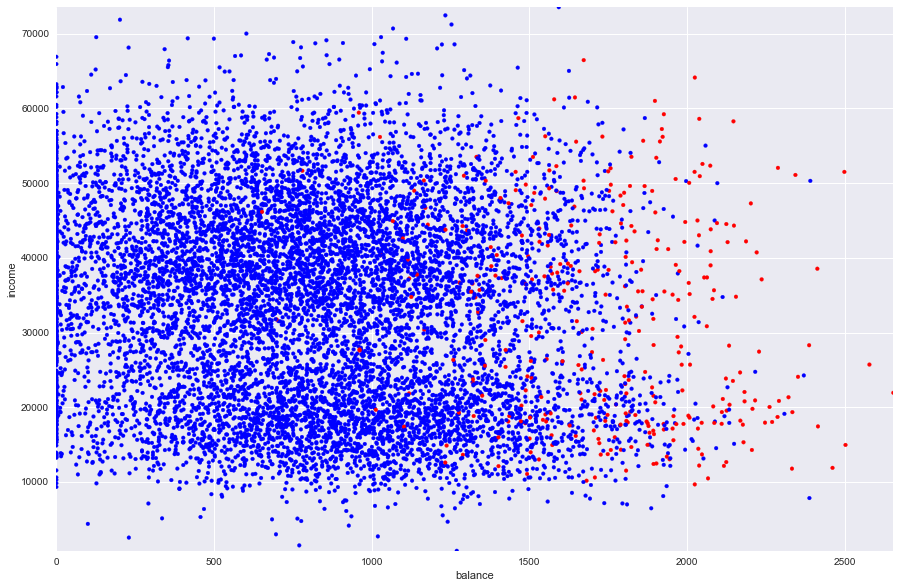

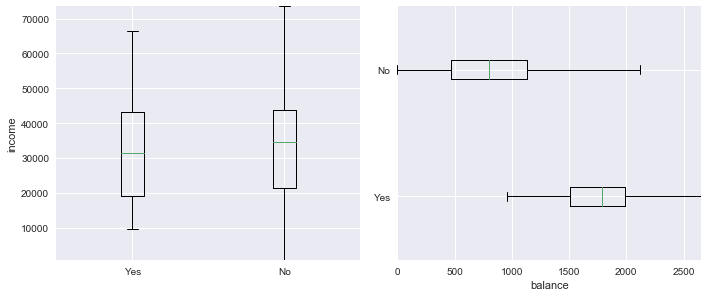

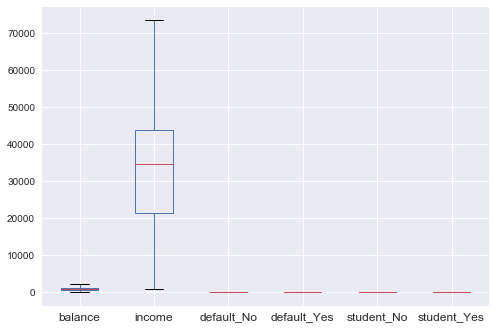

In [3]:
#3) Make boxplots of all of the variables and a scatter plot of of (balance,income) 
# with the color of the outcome of default labeled red if yes and blue if no.

# setup figure
plt.figure(figsize=(15, 10))

# scatter plot of balance (x) and income (y)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(df.balance, df.income, s = 14, c=(df.default == 'No'), cmap=cm_bright)        
plt.xlim((df.balance.min(), df.balance.max()))
plt.ylim((df.income.min(), df.income.max()))
plt.xlabel('balance')
plt.ylabel('income')

# box plots for income
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(221)
ax1.boxplot([df.income[df.default == 'Yes'], df.income[df.default == 'No']])
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xticklabels(('Yes', 'No'))
ax1.set_ylabel('income')

# box plots for balance
ax2 = plt.subplot(222)
ax2.boxplot([df.balance[df.default == 'Yes'], df.balance[df.default == 'No']], vert=0)
ax2.set_xlim((df.balance.min(), df.balance.max()))
ax2.set_yticklabels(('Yes', 'No'))
ax2.set_xlabel('balance')
plt.tight_layout()

plt.figure()
df_final.boxplot()

Area under the ROC curve : 0.953184


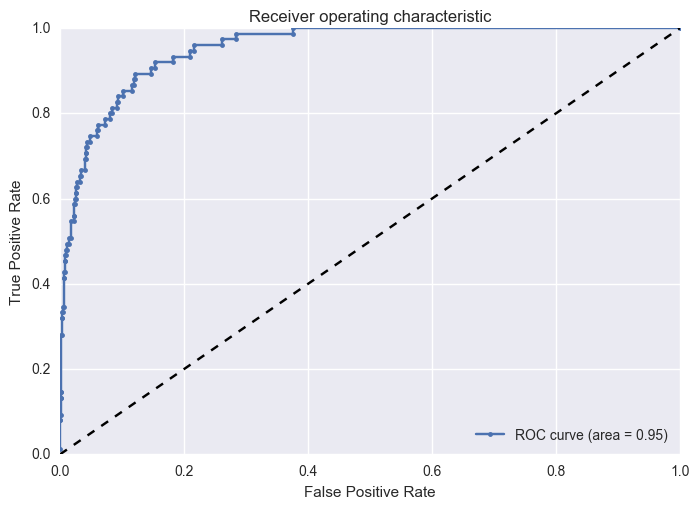

[[ 2.72374012  0.29992902]] [-6.16157509]


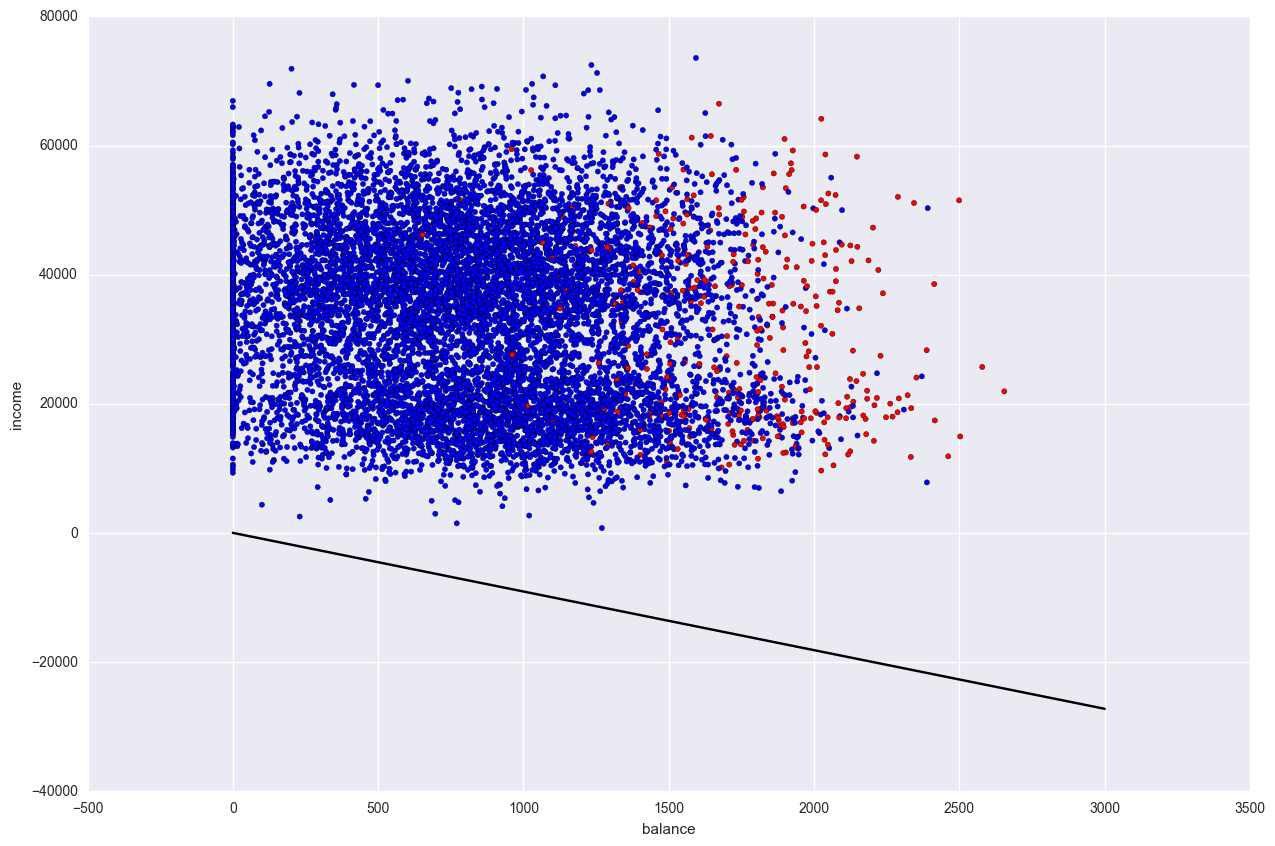

In [10]:
#4) Train a model to predict if a student defaults on their loan or not using LogisticRegression
# based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) 
# and compute the AUC ROC.

y = df_final['default_Yes']
X = df_final[['balance','income']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    #X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    #X_train, X_test = X[:half], X[half:]
    #y_train, y_test = y[:half], y[half:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % (roc_auc))
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Decision boundary plot
plt.figure(figsize=(15, 10))
clf = LogisticRegression(penalty='l1', C=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
clf.fit(X_train,y_train)
print (clf.coef_, clf.intercept_)


cm_bright = ListedColormap(['#FF0000', '#0000FF']) 

plt.plot(figsize=(10, 10))
intercept = clf.intercept_
c = clf.coef_[0]
dt = np.linspace(0, 3000, 1000)
y = (-intercept - c[0]*dt)/c[1]
plt.scatter(df.balance, df.income, s = 14, c=(df.default == 'No'), cmap=cm_bright)  
plt.plot(dt, y, 'k', label='Decision boundary')
plt.xlabel('balance')
plt.ylabel('income')

Area under the ROC curve : 0.952873


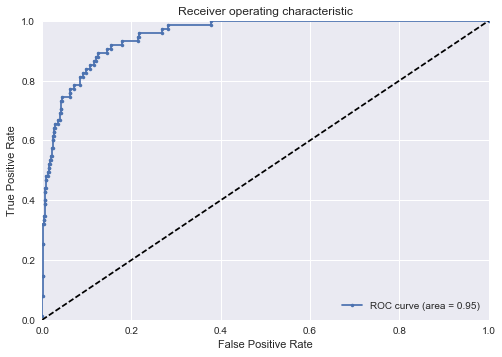

In [5]:
# Generate ROC  for Ridged with l2 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l2')

# Plots ROC
generate_ROCplot(fpr,tpr,'Ridge',roc_auc)

Area under the ROC curve : 0.953392


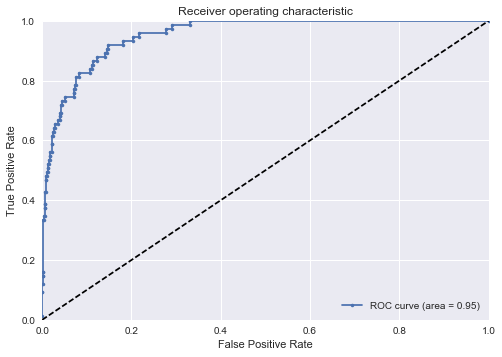

In [6]:
#5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. 
# How does performance improve with the added variable?

y = df_final['default_Yes'].copy()
X = df_final[['balance','income','student_Yes','student_No']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    #X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    #X_train, X_test = X[:half], X[half:]
    #y_train, y_test = y[:half], y[half:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % (roc_auc))
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

From the value of the ROC curve area, it is evident that including the student variable causes insignificant change to the model.

Area under the ROC curve : 0.968213


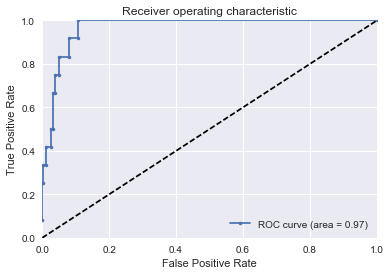

Area under the ROC curve : 0.969487


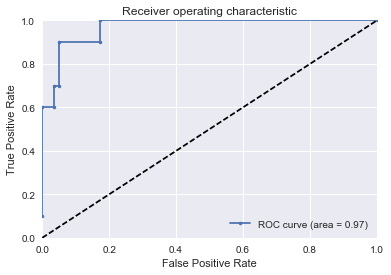

Area under the ROC curve : 0.975765


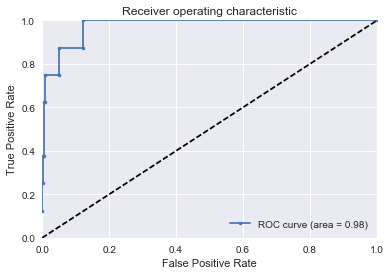

Area under the ROC curve : 0.973358


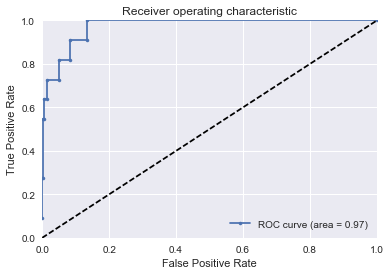

Area under the ROC curve : 0.967261


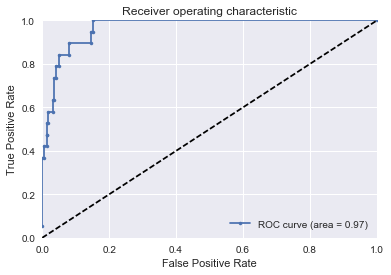

Area under the ROC curve : 0.934408


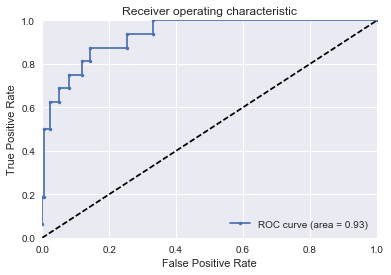

In [71]:
# 6) Using cross validation, check that the model you built in 5) is robust
# (generalizes to other random folds of the dataset).
folds = [10, 20, 30, 40, 50, 100]
for f in folds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=f)
    clf = LogisticRegression(penalty='l1', C=100)
    clf.fit(X_train, y_train)
    fpr,tpr,roc_auc, thresholds = generate_auc(X_test,y_test,LogisticRegression,C=100,penalty='l1')
    generate_ROCplot(fpr,tpr,'LR',roc_auc)

The model is robust as the AUC ROC is >0.95 across all the test cases.

In [3]:
y = df_final['default_Yes'].copy()
X = df_final[['balance','income']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [4]:
#7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. 
# How does performance compare?

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [5]:
from __future__ import print_function

import os
import subprocess

dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(model, feature_names=['x'])

In [6]:
dot_data=export_graphviz(model, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [12]:
# Fit regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

ValueError: Found input variables with inconsistent numbers of samples: [10000, 1000]

Optimum tree length is 3

In [11]:
dt=DecisionTreeRegressor(max_depth=n_opt)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'n_opt' is not defined

Area under the ROC curve : 0.940910


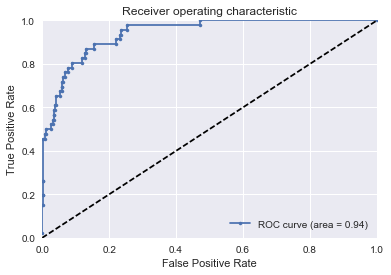

In [77]:
regr_opt = DecisionTreeRegressor(max_depth=n_opt)
regr_opt.fit(X, y)

fpr,tpr,roc_auc, thresholds = generate_auc(X_train,y_train,LogisticRegression,C=100,penalty='l1')

generate_ROCplot(fpr,tpr,'LR',roc_auc)